In [1]:
# imports
import psycopg2
import numpy as np
import pandas as pd
import json
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import interpolate

resolution = 100 # can head to config file

# access creds
with open('psql_key.json') as file:
    creds = json.load(file)

# Create an SQLAlchemy engine with the PostgreSQL database URI
engine = create_engine(f"postgresql+psycopg2://{creds['user']}:{creds['password']}@{creds['host']}:{creds['port']}/{creds['database']}")

In [2]:
# these diag codes were taken from table mimiciv_hosp.d_icd_diagnoses
hf_codes = "('39891','40200','40201','40210','40211','40290','40291','40400','40401','40402','40403','40410','40411','40412','40413','40490','40491','40492','40493','4280','4281','42820','42821','42822','42823','42830','42831','42832','42833','42840','42841','42842','42843','4289','E8726','E8745','I0981','I110','I119','I130','I131','I1310','I1311','I132','I50','I501','I502','I5020','I5021','I5022','I5023','I503','I5030','I5031','I5032','I5033','I504','I5040','I5041','I5042','I5043','I508','I5081','I50810','I50811','I50812','I50813','I50814','I5082','I5083','I5084','I5089','I509','I9713','I97130','I97131','T8622','T8632','Y625')"

# get all admissions related to HF codes
query = f'''
select a.* from (select * from mimiciv_hosp.diagnoses_icd where icd_code in {hf_codes}) d
inner join (select * from mimiciv_hosp.admissions) a
on a.hadm_id = d.hadm_id
'''
all_hf_pats = pd.read_sql_query(query , engine)

# QC
print(all_hf_pats['subject_id'].nunique())
# all_hf_pats.head(2)

# Count of times patients have been admitted with a HF diagnosis

hist_df = all_hf_pats.groupby('subject_id').agg({'admittime':'nunique'}).reset_index().groupby('admittime').agg({'subject_id':'nunique'}).reset_index()
hist_df.columns = ['num_admits' , 'patients']
hist_df['cumulative_patients'] = hist_df['patients'].cumsum()
# hist_df.head()

24348


In [3]:
# Retain all patients
# Add num of ICU admits / num of admissions as covariates
# Time of survival -> from last ICU admission to deathtime / OR first ICU admission?
# Uncensored patients (those that experienced the event, i.e. died)
# Find latest ICU admission
tos_hf = all_hf_pats.groupby('subject_id').agg({'admittime':'min' , 'deathtime':'max' , 'dischtime':'max'})
event_pats = tos_hf[tos_hf['deathtime'].notnull()].copy()
event_pats['time_to_event'] = event_pats['deathtime'] - event_pats['admittime']
event_pats['time_to_event'] = event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
event_pats['Uncensored'] = 1
event_pats.head(3)

,admittime,deathtime,dischtime,time_to_event,Uncensored
subject_id,,,,,
10003400,2136-12-09 14:44:00,2137-09-02 17:05:00,2137-09-02 17:05:00,267.097917,1
10004401,2141-06-06 19:20:00,2144-06-18 21:30:00,2144-06-18 21:30:00,1108.090278,1
10005817,2132-12-12 01:43:00,2135-01-19 18:36:00,2135-01-19 18:36:00,768.703472,1


In [4]:
# who are the censored patients?
non_event_pats = tos_hf[tos_hf['deathtime'].isnull()].copy()# For censored patients, their last follow-up was essentially their discharge time
non_event_pats['time_to_event'] = non_event_pats['dischtime'] - non_event_pats['admittime']
non_event_pats['time_to_event'] = non_event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
# non_event_pats['time_to_event'] = non_event_pats['time_to_event'] + 365 # is this necessary?
non_event_pats['Uncensored'] = 0
non_event_pats.head(3)

,admittime,deathtime,dischtime,time_to_event,Uncensored
subject_id,,,,,
10000980,2188-01-03 17:41:00,NaT,2193-08-17 15:07:00,2052.893056,0
10001667,2173-08-22 17:16:00,NaT,2173-08-24 16:45:00,1.978472,0
10001843,2131-11-09 16:05:00,NaT,2131-11-11 11:23:00,1.804167,0


In [5]:
pats = pd.concat([non_event_pats[['time_to_event' , 'Uncensored']] , event_pats[['time_to_event' , 'Uncensored']]] , axis = 0)
pats.reset_index(inplace = True)
pats.sort_values('subject_id' , inplace = True)
pats.head()

,subject_id,time_to_event,Uncensored
0,10000980,2052.893056,0
1,10001667,1.978472,0
2,10001843,1.804167,0
3,10001877,1.738889,0
4,10002013,2317.696528,0


In [6]:
# Try to get vital signs

query = f'''
select * from mimiciv_ed.vitalsign
'''
vitalsign = pd.read_sql_query(query , engine)
# pats_vitalsign = vitalsign.merge(pats['subject_id'] , on = 'subject_id' , how = 'inner')
# pats_vitalsign_list = pats_vitalsign.subject_id.unique()
# print(f'unique patients: {pats_vitalsign.subject_id.nunique()}')

# # Get survival
# pats_survival = pats.merge(vitalsign['subject_id'] , on = 'subject_id' , how = 'inner')
# print(f'unique patients: {pats_survival.subject_id.nunique()}')
# pats_survival.tail()

pats_all_metrics = vitalsign.merge(pats , on = 'subject_id' , how = 'inner')
print(f'unique patients: {pats_all_metrics.subject_id.nunique()}')
pats_all_metrics.tail()

unique patients: 16117


,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,time_to_event,Uncensored
331111,19998497,33623628,2144-01-13 01:02:00,98.4,76.0,18.0,98.0,130.0,74.0,None,0,1.103472,0
331112,19998497,35230154,2145-07-24 21:13:00,NaN,65.0,24.0,98.0,160.0,49.0,None,0,1.103472,0
331113,19998497,35230154,2145-07-24 23:10:00,NaN,62.0,16.0,98.0,147.0,51.0,None,0,1.103472,0
331114,19998497,35230154,2145-07-24 23:39:00,NaN,116.0,16.0,96.0,109.0,54.0,None,0,1.103472,0
331115,19998497,35230154,2145-07-24 23:55:00,98.1,61.0,16.0,100.0,155.0,58.0,None,0,1.103472,0


## **Build patient Image**

In [7]:
from my_algo.patient_image import Patient_Image_Builder
pib = Patient_Image_Builder(data = pats_all_metrics, 
                            cov_cols = ['temperature','heartrate','resprate','o2sat','sbp','dbp'],
                            resolution = 100 , 
                            subject_col = 'subject_id' , 
                            obs_time = 'charttime'
                            )

# build image
data = pib.build_img(verbose = True)
print(f'shape: {data.shape}')

init complete
unique patients: 16117
1000 patients done
2000 patients done
3000 patients done
4000 patients done
5000 patients done
6000 patients done
7000 patients done
8000 patients done
9000 patients done
10000 patients done
11000 patients done
12000 patients done
13000 patients done
14000 patients done
15000 patients done
16000 patients done
shape: (16117, 100, 6)


In [8]:
data_flatten = data.mean(axis = 1)
data.shape , data_flatten.shape

((16117, 100, 6), (16117, 6))

In [9]:
from my_algo.transforms import Transforms
transf = Transforms()
b = transf.bin_duration(data = pats_all_metrics , subject_col = 'subject_id' , dur_col = 'time_to_event' , eve_col = 'Uncensored' , cuts = 10)
dur_ = b[: , 1]
dur_idx = b[: , 2]
events = b[: , 3]

----------------------------------------------

In [10]:
import torch
import torch.nn as nn

# data_rshp = torch.Tensor(data.reshape(data.shape[0] , 1 , data.shape[1] , data.shape[2]))

# calc for linear layer
# input_size = int(32*((((data_rshp.shape[2]-2)/1+1)-2)/1+1)*((((data_rshp.shape[3]-2)/1+1)-2)/1+1))
input_size = data_flatten.shape[1]

# assert input_size == 32*98*4 , 'shapes not matching for fc input size'
hidden_size = 32
output_size = transf.n_bucket_indices
dropout = 0.1

print(f'input {input_size} , output {output_size}')
# conv_layer(data.reshape(data.shape[0] , 1 , data.shape[1] , data.shape[2]))

input 6 , output 11


In [12]:
from my_algo.utils import *

# Create an instance of your custom dataset
dataset = MyDataset(data_flatten, dur_idx, events)

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 50
learning_rate = 0.001
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
class Conv_Net(nn.Module):
    def __init__(self , fc_input_size , fc_hidden_size , fc_output_size , dropout_rate):
        super(Conv_Net , self).__init__()
        # Convolutional Net
        self.conv_net = nn.Sequential(
                    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    # torch.Size([n_batch, 16, 100, 6]) |-> torch.Size([n_batch, 16, height, width])
                    nn.MaxPool2d(kernel_size=2, stride=1),
                    # torch.Size([n_batch, 16, 99, 5]) |-> torch.Size([n_batch, 16, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
                    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    # torch.Size([n_batch, 32, 99, 5]) |-> torch.Size([n_batch, 32, height, width])
                    nn.MaxPool2d(kernel_size=2, stride=1),
                    # torch.Size([n_batch, 32, 98, 4]) |-> torch.Size([n_batch, 32, (height-kernel_size)/stride+1, (width-kernel_size)/stride+1])
                    nn.Flatten()
                )
        # Fully connected
        self.fc_net = nn.Sequential(
            nn.Linear(fc_input_size, fc_hidden_size), nn.ReLU(), nn.BatchNorm1d(fc_hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden_size, fc_hidden_size), nn.ReLU(), nn.BatchNorm1d(fc_hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden_size, fc_output_size)
        )
    
    def forward(self , x):
        # forward pass
        output = self.conv_net(x)
        # print(f'shape after conv net: {output.shape}')
        output = self.fc_net(output)
        # print(f'shape after fc net: {output.shape}')
        return output

In [13]:
class FC_Net(nn.Module):
    def __init__(self , fc_input_size , fc_hidden_size , fc_output_size , dropout_rate):
        super(FC_Net , self).__init__()
        
        # Fully connected
        self.fc_net = nn.Sequential(
            nn.Linear(fc_input_size, fc_hidden_size), nn.ReLU(), nn.BatchNorm1d(fc_hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden_size, fc_hidden_size), nn.ReLU(), nn.BatchNorm1d(fc_hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden_size, fc_output_size)
        )
    
    def forward(self , x):
        # forward pass
        # output = self.conv_net(x)
        # print(f'shape after conv net: {output.shape}')
        output = self.fc_net(x)
        # print(f'shape after fc net: {output.shape}')
        return output

In [ ]:
# import torch
# import torch.nn as nn

# # Define input tensor
# input_tensor = torch.rand((245 , 6))

# # Define linear layer
# linear_layer = nn.Linear(6, 30)  # Input size: 3, output size: 3

# # Perform pass-through operation
# output = linear_layer(input_tensor)

# # print(output.shape) , 
# input_tensor.dtype

torch.float32

In [14]:
# init model
# model = Conv_Net(input_size , hidden_size , output_size , dropout_rate = dropout)
model = FC_Net(input_size , hidden_size , output_size , dropout_rate = dropout)

# init optim
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

In [15]:
# Training loop
for epoch in range(num_epochs):
    for batch_id , (pat_img , dur , eve) in enumerate(dataloader):
        # Prime for training
        model.train()
        # print(f'dimension {cov.shape} , {dur.shape} , {eve.shape}')
        # forward pass
        phi_train = model(torch.Tensor(pat_img).type(torch.float32))
        # print(f'phi train dimension {phi_train.shape}')

        # get loss
        loss = nll_logistic_hazard(phi_train , dur , eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # # Prime for evaluation
        # model.eval()
        # with torch.no_grad():
        #     phi_val = model(torch.Tensor(x_val))
        #     val_loss = nll_logistic_hazard(phi_val, dur_idx_val , events_val)
        
        # # Check if validation loss has improved
        # if val_loss < best_loss:
        #     best_loss = val_loss
        #     counter = 0
        # else:
        #     counter += 1

        # # Check if early stopping condition is met
        # if counter >= patience:
        #     print(f"Early stopping at epoch {epoch}.")
        #     break

    print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, ") 

# turn training off
model.eval()

Epoch 1: Training Loss: 1.6447, 
Epoch 2: Training Loss: 1.2901, 
Epoch 3: Training Loss: 0.8762, 
Epoch 4: Training Loss: 0.5702, 
Epoch 5: Training Loss: 0.4675, 
Epoch 6: Training Loss: 0.4549, 
Epoch 7: Training Loss: 0.4568, 
Epoch 8: Training Loss: 0.4245, 
Epoch 9: Training Loss: 0.4301, 
Epoch 10: Training Loss: 0.4591, 
Epoch 11: Training Loss: 0.3750, 
Epoch 12: Training Loss: 0.4161, 
Epoch 13: Training Loss: 0.5000, 
Epoch 14: Training Loss: 0.4997, 
Epoch 15: Training Loss: 0.4740, 
Epoch 16: Training Loss: 0.3440, 
Epoch 17: Training Loss: 0.3522, 
Epoch 18: Training Loss: 0.3810, 
Epoch 19: Training Loss: 0.4493, 
Epoch 20: Training Loss: 0.4662, 
Epoch 21: Training Loss: 0.4138, 
Epoch 22: Training Loss: 0.5302, 
Epoch 23: Training Loss: 0.3493, 
Epoch 24: Training Loss: 0.3845, 
Epoch 25: Training Loss: 0.4275, 
Epoch 26: Training Loss: 0.3531, 
Epoch 27: Training Loss: 0.4510, 
Epoch 28: Training Loss: 0.4730, 
Epoch 29: Training Loss: 0.3619, 
Epoch 30: Training Loss

FC_Net(
  (fc_net): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=32, out_features=11, bias=True)
  )
)

In [19]:
#testing
epsilon = 1e-8
hazards = torch.sigmoid(model(torch.Tensor(data_flatten)))
# survival = torch.cumprod(1 - hazards , dim = 1)
survival = (1 - hazards).add(epsilon).log().cumsum(1).exp()

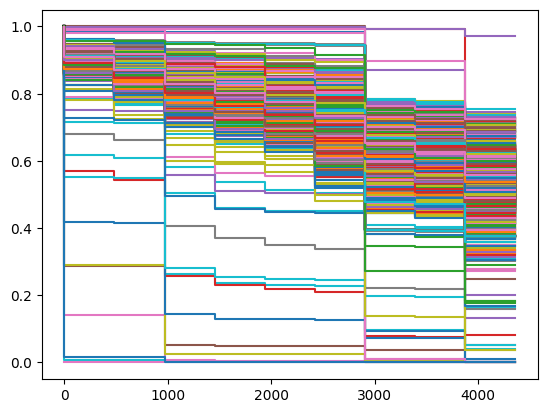

In [20]:
for surv in survival:
    plt.step(np.concatenate((np.array([0]) , transf.bin_edges)) , surv.detach().numpy());

In [16]:
# from pycox.evaluation import EvalSurv
# from pycox.evaluation.concordance import concordance_td

from eval_surv_copy import EvalSurv
import pickle

with open('survival.pkl', 'rb') as f:
    survival = pickle.load(f)

In [17]:
# # survival.T.shape , dur_idx.shape , events.shape , dur_.shape ,
# np_survival = survival.detach().numpy()
# # np.arange(dur_.shape[0]).shape
# import pickle

# # Pickle the NumPy array to a file
# with open('survival.pkl', 'wb') as f:
#     pickle.dump(np_survival, f)

In [22]:
# concordance_td(dur_ , events , survival.T ,  np.arange(dur_.shape[0]))

ev = EvalSurv(pd.DataFrame(survival.T), dur_, events, censor_surv='km')

In [23]:
# ev.concordance_td('antolini')

shapes : (16117, 16117, 16117, 16117)


KeyboardInterrupt: 

----------------------------------------

In [1]:
from my_algo.utils import *
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

init complete


In [2]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [3]:
# from my_algo.transforms import Transforms
# transf = Transforms()
# b = transf.bin_duration(data = df_train , subject_col = 'subject_id' , dur_col = 'time_to_event' , eve_col = 'Uncensored' , cuts = 10)
# dur_ = b[: , 1]
# dur_idx = b[: , 2]
# events = b[: , 3]

In [4]:
# Hyper Params
input_size = x_train.shape[1]
hidden_size = 32
output_size = labtrans.out_features
# batch_norm = True
dropout = 0.1
learning_rate = 0.01
num_epochs = 100

# Convert dtypes
dur_idx = torch.Tensor(y_train[0].astype('int'))
events = torch.Tensor(y_train[1].astype('int') )

dur_idx_val = torch.Tensor(y_val[0].astype('int'))
events_val = torch.Tensor(y_val[1].astype('int') )

# Define early stopping parameters
patience = 10
best_loss = float('inf')
counter = 0

# init model
model = MLP(input_size , hidden_size , output_size , dropout_rate = dropout)

# init optim
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

# Create an instance of your custom dataset
dataset = MyDataset(x_train, dur_idx, events)

# Create a data loader for batching and shuffling
batch_size = 256
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
# Training loop
for epoch in range(num_epochs):
    for batch_id , (cov , dur , eve) in enumerate(dataloader):
        # Prime for training
        model.train()
        # print(f'dimension {cov.shape} , {dur.shape} , {eve.shape}')
        # forward pass
        phi_train = model(torch.Tensor(cov))
        # print(f'phi train dimension {phi_train.shape}')

        # get loss
        loss = nll_logistic_hazard(phi_train , dur , eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Prime for evaluation
        model.eval()
        with torch.no_grad():
            phi_val = model(torch.Tensor(x_val))
            val_loss = nll_logistic_hazard(phi_val, dur_idx_val , events_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

    print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, ") 

# turn training off
model.eval()

Epoch 1: Training Loss: 3.1451, 
Epoch 2: Training Loss: 2.6208, 
Epoch 3: Training Loss: 2.3484, 
Epoch 4: Training Loss: 2.0837, 
Epoch 5: Training Loss: 1.6210, 
Epoch 6: Training Loss: 1.4461, 
Epoch 7: Training Loss: 1.4334, 
Epoch 8: Training Loss: 1.3730, 
Epoch 9: Training Loss: 1.5211, 
Epoch 10: Training Loss: 1.3239, 
Early stopping at epoch 10.
Epoch 11: Training Loss: 1.3497, 
Early stopping at epoch 11.
Epoch 12: Training Loss: 1.2848, 
Early stopping at epoch 12.
Epoch 13: Training Loss: 1.3527, 
Early stopping at epoch 13.
Epoch 14: Training Loss: 1.2436, 
Early stopping at epoch 14.
Epoch 15: Training Loss: 1.4242, 
Early stopping at epoch 15.
Epoch 16: Training Loss: 1.2829, 
Early stopping at epoch 16.
Epoch 17: Training Loss: 1.3738, 
Early stopping at epoch 17.
Epoch 18: Training Loss: 1.3395, 
Early stopping at epoch 18.
Epoch 19: Training Loss: 1.3166, 
Early stopping at epoch 19.
Epoch 20: Training Loss: 1.3430, 
Early stopping at epoch 20.
Epoch 21: Training Lo

MLP(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [6]:
#testing
hazards = torch.sigmoid(model(torch.Tensor(x_test)))
survival = torch.cumprod(1 - hazards , dim = 1)

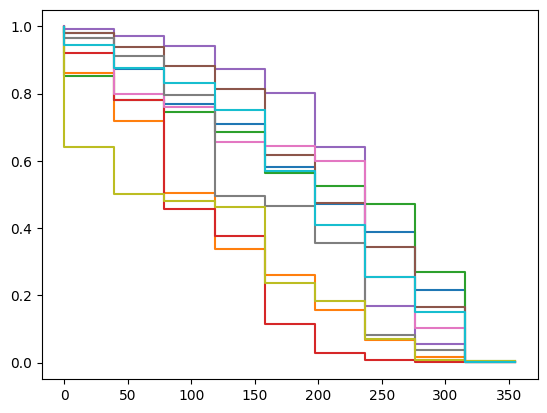

In [9]:
for surv in survival[300:310]:
    plt.step(labtrans.cuts , surv.detach().numpy());